In [ ]:
#Experimenting with Layer Depth Amplification Dependece  filtering  code for MNIST dataset
#   Omada 2 -- Grokfast experiments

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!ls /content/drive/MyDrive/PatRec_Project_Shared_Folder/

Algorithmic_code  MNIST_code	  __pycache__  requirements.txt  results2_test_random_seed_12
grokfast.py	  _Presentations  QM9_code     results


In [7]:
import sys
sys.path.append('/content/drive/MyDrive/PatRec_Project_Shared_Folder')

In [26]:
!pip install -r /content/drive/MyDrive/PatRec_Project_Shared_Folder/requirements.txt

In [8]:
import random
import time
import math
import argparse
from argparse import ArgumentParser
from collections import defaultdict
from itertools import islice
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torchvision
from typing import List, Optional, Dict, Literal
from collections import deque


In [9]:
from grokfast import gradfilter_ma, gradfilter_ema

In [10]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

In [11]:
def compute_accuracy(network, dataset, device, N=2000, batch_size=50):
    """Computes accuracy of `network` on `dataset`.
    """
    with torch.no_grad():
        N = min(len(dataset), N)
        batch_size = min(batch_size, N)
        dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        correct = 0
        total = 0
        for x, labels in islice(dataset_loader, N // batch_size):
            logits = network(x.to(device))
            predicted_labels = torch.argmax(logits, dim=1)
            correct += torch.sum(predicted_labels == labels.to(device))
            total += x.size(0)
        return (correct / total).item()


def compute_loss(network, dataset, loss_function, device, N=2000, batch_size=50):
    """Computes mean loss of `network` on `dataset`.
    """
    with torch.no_grad():
        N = min(len(dataset), N)
        batch_size = min(batch_size, N)
        dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        loss_fn = loss_function_dict[loss_function](reduction='sum')
        one_hots = torch.eye(10, 10).to(device)
        total = 0
        points = 0
        for x, labels in islice(dataset_loader, N // batch_size):
            y = network(x.to(device))
            if loss_function == 'CrossEntropy':
                total += loss_fn(y, labels.to(device)).item()
            elif loss_function == 'MSE':
                total += loss_fn(y, one_hots[labels]).item()
            points += len(labels)
        return total / points



In [12]:
optimizer_dict = {
    'AdamW': torch.optim.AdamW,
    'Adam': torch.optim.Adam,
    'SGD': torch.optim.SGD
}

activation_dict = {
    'ReLU': nn.ReLU,
    'Tanh': nn.Tanh,
    'Sigmoid': nn.Sigmoid,
    'GELU': nn.GELU
}

loss_function_dict = {
    'MSE': nn.MSELoss,
    'CrossEntropy': nn.CrossEntropyLoss
}

In [13]:
import os
# Ensure the 'results' directory exists
results_dir = "/content/drive/MyDrive/PatRec_Project_Shared_Folder/results/MNIST"


In [14]:
# Comment after first time
# Download dataset

import torchvision

dataset_path = '/content/drive/MyDrive/PatRec_Project_Shared_Folder/MNIST_code/MNIST_data'
train_dataset = torchvision.datasets.MNIST(
    root=dataset_path, train=True, transform=torchvision.transforms.ToTensor(), download=True)


In [15]:
from collections import Counter
from sklearn.model_selection import train_test_split


def main(args):
    log_freq = math.ceil(args.optimization_steps / 150)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dtype = torch.float32

    torch.set_default_dtype(dtype)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    random.seed(args.seed)
    np.random.seed(args.seed)

    # load dataset
    # not needed , we have done it above
    # train_dataset = torchvision.datasets.MNIST(
    #     root=dataset_path, train=True, transform=torchvision.transforms.ToTensor(), download=True
    # )

    # Create indices stratified by digit labels
    train_indices = list(range(len(train_dataset)))
    train_labels = [train_dataset.targets[i].item() for i in train_indices]

    args.train_points = 1000
    # Use train_test_split with stratification to randomly select a specified number of samples (args.train_points)
    stratified_indices, _ = train_test_split(
        train_indices,
        train_size=args.train_points,
        stratify=train_labels,
        random_state=args.seed
    )

    # Create a subset with the stratified indices
    train_subset = torch.utils.data.Subset(train_dataset, stratified_indices)
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=args.batch_size, shuffle=True)

    test = torchvision.datasets.MNIST(root=args.download_directory, train=False,
        transform=torchvision.transforms.ToTensor(), download=True)

    # only predefined activation functions are allowed
    assert args.activation in activation_dict, f"Unsupported activation function: {args.activation}"
    activation_fn = activation_dict[args.activation]

    print(f"Stratified train subset created with {len(stratified_indices)} samples.")

    # Create model
    layers = [nn.Flatten()]
    for i in range(args.depth):
        if i == 0:
            layers.append(nn.Linear(784, args.width))
            layers.append(activation_fn())
        elif i == args.depth - 1:
            layers.append(nn.Linear(args.width, 10))
        else:
            layers.append(nn.Linear(args.width, args.width))
            layers.append(activation_fn())
    mlp = nn.Sequential(*layers).to(device)

    with torch.no_grad():  #initialization
        for p in mlp.parameters():
            p.data = args.initialization_scale * p.data
    # only trainable parameters are counted.
    nparams = sum([p.numel() for p in mlp.parameters() if p.requires_grad])
    print(f'Number of parameters: {nparams}')

    # create optimizer
    assert args.optimizer in optimizer_dict, f"Unsupported optimizer choice: {args.optimizer}"
    optimizer = optimizer_dict[args.optimizer](mlp.parameters(), lr=args.lr, weight_decay=args.weight_decay)

    # define loss function
    assert args.loss_function in loss_function_dict
    loss_fn = loss_function_dict[args.loss_function]()


    #     Start Training below
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], [] # loss, accuracy values
    norms, last_layer_norms, log_steps = [], [], []
    grads = None

    steps = 0
    one_hots = torch.eye(10, 10).to(device)
    with tqdm(total=args.optimization_steps, dynamic_ncols=True) as pbar:
        for x, labels in islice(cycle(train_loader), args.optimization_steps):
            do_log = (steps < 30) or (steps < 150 and steps % 10 == 0) or steps % log_freq == 0
            if do_log:
                train_losses.append(compute_loss(mlp, train_subset, args.loss_function, device, N=len(train_subset)))
                train_accuracies.append(compute_accuracy(mlp, train_subset, device, N=len(train_subset)))
                test_losses.append(compute_loss(mlp, test, args.loss_function, device, N=len(test)))
                test_accuracies.append(compute_accuracy(mlp, test, device, N=len(test)))
                log_steps.append(steps)

                pbar.set_description(
                    "L: {0:1.1e}|{1:1.1e}. A: {2:2.1f}%|{3:2.1f}%".format(
                        train_losses[-1],
                        test_losses[-1],
                        train_accuracies[-1] * 100,
                        test_accuracies[-1] * 100,
                    )
                )

            # forward pass
            y = mlp(x.to(device))

            if args.loss_function == 'CrossEntropy':
                loss = loss_fn(y, labels.to(device))
            elif args.loss_function == 'MSE':
                loss = loss_fn(y, one_hots[labels])

            # Clears old gradients
            optimizer.zero_grad()
            # Computes gradients using backpropagation
            loss.backward()

            #######
            # gradient filtering
            trigger = False

            if args.filter == "none":
                pass
            elif args.filter == "ma":
                grads = gradfilter_ma(mlp, grads=grads, window_size=args.window_size, lamb=args.lamb, trigger=trigger)
            elif args.filter == "ema":
                grads = gradfilter_ema(mlp, grads=grads, alpha=args.alpha, lamb=args.lamb)
            else:
                raise ValueError(f"Invalid gradient filter type `{args.filter}`")

            #######

            optimizer.step()

            steps += 1
            pbar.update(1)

            if do_log:
                title = (f"MNIST Image Classification")

                plt.plot(log_steps, train_accuracies, label="train")
                plt.plot(log_steps, test_accuracies, label="val")
                plt.legend()
                plt.title(title)
                plt.xlabel("Optimization Steps")
                plt.ylabel("Accuracy")
                plt.xscale("log", base=10)
                plt.grid()
                plt.savefig(f"{results_dir}/mnist_acc_{args.label}.png", dpi=150)
                plt.close()

                plt.plot(log_steps, train_losses, label="train")
                plt.plot(log_steps, test_losses, label="val")
                plt.legend()
                plt.title(title)
                plt.xlabel("Optimization Steps")
                plt.ylabel(f"{args.loss_function} Loss")
                plt.xscale("log", base=10)
                plt.yscale("log", base=10)
                plt.grid()
                plt.savefig(f"{results_dir}/mnist_loss_{args.label}.png", dpi=150)
                plt.close()

                # Save results
                results_filename = os.path.join(results_dir, f"mnist_{args.label}.pt")
                torch.save({
                    'its': log_steps,
                    'train_acc': train_accuracies,
                    'train_loss': train_losses,
                    'val_acc': test_accuracies,
                    'val_loss': test_losses,
                }, results_filename)


In [2]:
import sys
from argparse import ArgumentParser

# Remove the extra arguments passed by the Jupyter Notebook kernel
sys.argv = ['']

In [3]:
# --filter = none

Experiment results saved under name: none_w_decay0000
Stratified train subset created with 1000 samples.
Number of parameters: 199210


  0%|          | 0/100000 [00:00<?, ?it/s]

<ipython-input-15-a63573905b5a>:146: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale("log", base=10)
<ipython-input-15-a63573905b5a>:157: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale("log", base=10)


KeyboardInterrupt: 

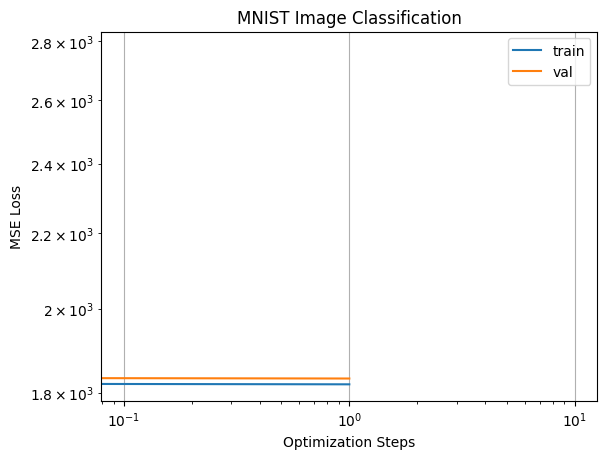

In [16]:
if __name__ == '__main__':
    # all the same as grokfast
    parser = ArgumentParser()
    parser.add_argument("--label", default="")
    parser.add_argument("--seed", type=int, default=0)

    parser.add_argument("--train_points", type=int, default=1000)
    parser.add_argument("--optimization_steps", type=int, default=100000)
    parser.add_argument("--batch_size", type=int, default=200)
    parser.add_argument("--loss_function", type=str, default="MSE")
    parser.add_argument("--optimizer", type=str, default="AdamW")
    parser.add_argument("--weight_decay", type=float, default=2)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--initialization_scale", type=float, default=8.0)
    parser.add_argument("--download_directory", type=str, default=".")
    parser.add_argument("--depth", type=int, default=3)
    parser.add_argument("--width", type=int, default=200)
    parser.add_argument("--activation", type=str, default="ReLU")

    # Grokfast with ema_depth filtering
    # new modify of the parser for ema_depth
    parser.add_argument("--filter", type=str, choices=["none", "ma", "ema",], default="none")
    parser.add_argument("--alpha", type=float, default=0.99,help="EMA decay factor")
    parser.add_argument("--lamb_max", type=float, default=3.0, )
    parser.add_argument("--lamb_min", type=float, default=1.0, )
    parser.add_argument("--d_max", type=int, default=3, help="Total number of transformer layers")
    parser.add_argument("--filter_type", type=str, choices=["mean", "sum"], default="mean", help="Filter type to be applied to gradients")
    parser.add_argument("--warmup", type=bool, default=True, help="Whether to apply warmup strategy for filtering")


    # the same as the grokfast
    parser.add_argument("--window_size", type=int, default=100)
    parser.add_argument("--lamb", type=float, default=5.0)

    args = parser.parse_args([
    "--weight_decay", "0.0",
    ])

    filter_str = ('_' if args.label != '' else '') + args.filter
    # window_size_str = f'_windowsize{args.window_size}'
    # alpha_str = f'_alpha{args.alpha:.3f}'.replace('.', '')
    weight_decay_str = f'_w_decay{args.weight_decay:.3f}'.replace('.', '')
    # lamb_str = f'_lambda{args.lamb:.2f}'.replace('.', '')


    if args.filter == 'none':
        filter_suffix = weight_decay_str
    elif args.filter == 'ma':
        filter_suffix = window_size_str + lamb_str
    elif args.filter == 'ema':
        filter_suffix = alpha_str + lamb_str
    else:
        raise ValueError(f"Unrecognized filter type {args.filter}")


    args.label = args.label + filter_str + filter_suffix
    print(f'Experiment results saved under name: {args.label}')

    main(args)

In [ ]:

# Load the saved results file to visualize plots later
results_filename = os.path.join(results_dir, f"mnist_{args.label}.pt")
if os.path.exists(results_filename):
    data = torch.load(results_filename)
else:
    print(f"File {results_filename} not found!")


<ipython-input-32-741e525a99d8>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(results_filename)


In [ ]:
# Define paths for saving accuracy and loss plots
accuracy_plot_path = os.path.join(results_dir, f"mnist_accuracy_{args.label}.png")
loss_plot_path = os.path.join(results_dir, f"mnist_loss_{args.label}.png")

In [ ]:
# Plot Accuracy
plt.plot(data['its'], data['train_acc'], label="Train Accuracy")
plt.plot(data['its'], data['val_acc'], label="Validation Accuracy")
plt.title("Ema_depth Accuracy over Optimization Steps, λ_max = 3 m λ_min = 1")
plt.xlabel("Optimization Steps")
plt.ylabel("Accuracy")
plt.xscale("log")
plt.legend()
plt.grid()
plt.savefig(accuracy_plot_path, dpi=150)
plt.close()
print(f"Accuracy plot saved to {accuracy_plot_path}")

# Plot Loss
plt.plot(data['its'], data['train_loss'], label="Train Loss")
plt.plot(data['its'], data['val_loss'], label="Validation Loss")
plt.title("Ema_depth Loss over Optimization Steps, λ_max = 3 m λ_min = 1")
plt.xlabel("Optimization Steps")
plt.ylabel("Loss")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid()
plt.savefig(loss_plot_path, dpi=150)
plt.close()
print(f"Loss plot saved to {loss_plot_path}")


Accuracy plot saved to /content/drive/MyDrive/PatRec_Project_Shared_Folder/results/MNIST/mnist_accuracy_ema_depth_windowsize100_alpha0980_lambda010_l_max3_l_min1_depth3.png
Loss plot saved to /content/drive/MyDrive/PatRec_Project_Shared_Folder/results/MNIST/mnist_loss_ema_depth_windowsize100_alpha0980_lambda010_l_max3_l_min1_depth3.png


In [ ]:
# Running none with wd = 0.01

Experiment results saved under name: none_w_decay0010
Stratified train subset created with 1000 samples.
Number of parameters: 199210


  0%|          | 0/100000 [00:00<?, ?it/s]

<ipython-input-15-a63573905b5a>:146: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale("log", base=10)
<ipython-input-15-a63573905b5a>:157: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale("log", base=10)


KeyboardInterrupt: 

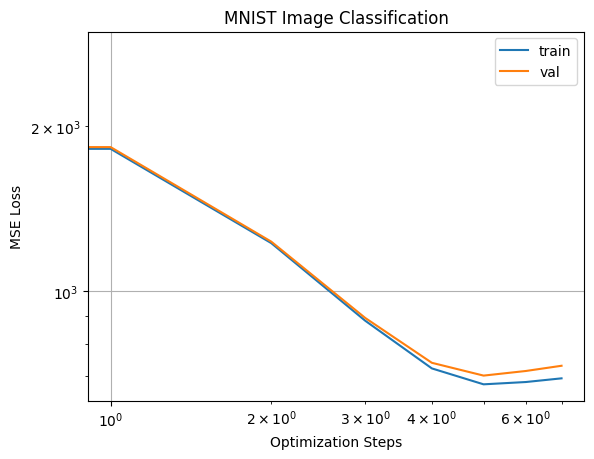

In [17]:
if __name__ == '__main__':
    # all the same as grokfast
    parser = ArgumentParser()
    parser.add_argument("--label", default="")
    parser.add_argument("--seed", type=int, default=0)

    parser.add_argument("--train_points", type=int, default=1000)
    parser.add_argument("--optimization_steps", type=int, default=100000)
    parser.add_argument("--batch_size", type=int, default=200)
    parser.add_argument("--loss_function", type=str, default="MSE")
    parser.add_argument("--optimizer", type=str, default="AdamW")
    parser.add_argument("--weight_decay", type=float, default=2)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--initialization_scale", type=float, default=8.0)
    parser.add_argument("--download_directory", type=str, default=".")
    parser.add_argument("--depth", type=int, default=3)
    parser.add_argument("--width", type=int, default=200)
    parser.add_argument("--activation", type=str, default="ReLU")

    # Grokfast with ema_depth filtering
    # new modify of the parser for ema_depth
    parser.add_argument("--filter", type=str, choices=["none", "ma", "ema", "ema_depth"], default="none")
    parser.add_argument("--alpha", type=float, default=0.99,help="EMA decay factor")
    parser.add_argument("--lamb_max", type=float, default=3.0, )
    parser.add_argument("--lamb_min", type=float, default=1.0, )
    parser.add_argument("--d_max", type=int, default=3, help="Total number of transformer layers")
    parser.add_argument("--filter_type", type=str, choices=["mean", "sum"], default="mean", help="Filter type to be applied to gradients")
    parser.add_argument("--warmup", type=bool, default=True, help="Whether to apply warmup strategy for filtering")
    # parser.add_argument("--embedding_layer_name", type=str, default="embedding", help="Name of embedding layers")
    # parser.add_argument("--final_and_output_layer_names", type=str, nargs='+', default=["ln_f", "head"], help="Names of final and output layers")

    # the same as the grokfast
    parser.add_argument("--window_size", type=int, default=100)
    parser.add_argument("--lamb", type=float, default=5.0)

    args = parser.parse_args([
    "--weight_decay", "0.01",
    ])

    filter_str = ('_' if args.label != '' else '') + args.filter
    # window_size_str = f'_windowsize{args.window_size}'
    # alpha_str = f'_alpha{args.alpha:.3f}'.replace('.', '')
    weight_decay_str = f'_w_decay{args.weight_decay:.3f}'.replace('.', '')
    # lamb_str = f'_lambda{args.lamb:.2f}'.replace('.', '')


    if args.filter == 'none':
        filter_suffix = weight_decay_str
    elif args.filter == 'ma':
        filter_suffix = window_size_str + lamb_str
    elif args.filter == 'ema':
        filter_suffix = alpha_str + lamb_str
    else:
        raise ValueError(f"Unrecognized filter type {args.filter}")


    args.label = args.label + filter_str + filter_suffix
    print(f'Experiment results saved under name: {args.label}')

    main(args)

In [ ]:
 # none wd = 0.1

In [18]:
if __name__ == '__main__':
    # all the same as grokfast
    parser = ArgumentParser()
    parser.add_argument("--label", default="")
    parser.add_argument("--seed", type=int, default=0)

    parser.add_argument("--train_points", type=int, default=1000)
    parser.add_argument("--optimization_steps", type=int, default=100000)
    parser.add_argument("--batch_size", type=int, default=200)
    parser.add_argument("--loss_function", type=str, default="MSE")
    parser.add_argument("--optimizer", type=str, default="AdamW")
    parser.add_argument("--weight_decay", type=float, default=2)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--initialization_scale", type=float, default=8.0)
    parser.add_argument("--download_directory", type=str, default=".")
    parser.add_argument("--depth", type=int, default=3)
    parser.add_argument("--width", type=int, default=200)
    parser.add_argument("--activation", type=str, default="ReLU")

    # Grokfast with ema_depth filtering
    # new modify of the parser for ema_depth
    parser.add_argument("--filter", type=str, choices=["none", "ma", "ema", "ema_depth"], default="none")
    parser.add_argument("--alpha", type=float, default=0.99,help="EMA decay factor")
    parser.add_argument("--lamb_max", type=float, default=3.0, )
    parser.add_argument("--lamb_min", type=float, default=1.0, )
    parser.add_argument("--d_max", type=int, default=3, help="Total number of transformer layers")
    parser.add_argument("--filter_type", type=str, choices=["mean", "sum"], default="mean", help="Filter type to be applied to gradients")
    parser.add_argument("--warmup", type=bool, default=True, help="Whether to apply warmup strategy for filtering")
    # parser.add_argument("--embedding_layer_name", type=str, default="embedding", help="Name of embedding layers")
    # parser.add_argument("--final_and_output_layer_names", type=str, nargs='+', default=["ln_f", "head"], help="Names of final and output layers")

    # the same as the grokfast
    parser.add_argument("--window_size", type=int, default=100)
    parser.add_argument("--lamb", type=float, default=5.0)

    args = parser.parse_args([
    "--weight_decay", "0.1",
    ])

    filter_str = ('_' if args.label != '' else '') + args.filter
    # window_size_str = f'_windowsize{args.window_size}'
    # alpha_str = f'_alpha{args.alpha:.3f}'.replace('.', '')
    weight_decay_str = f'_w_decay{args.weight_decay:.3f}'.replace('.', '')
    # lamb_str = f'_lambda{args.lamb:.2f}'.replace('.', '')


    if args.filter == 'none':
        filter_suffix = weight_decay_str
    elif args.filter == 'ma':
        filter_suffix = window_size_str + lamb_str
    elif args.filter == 'ema':
        filter_suffix = alpha_str + lamb_str
    else:
        raise ValueError(f"Unrecognized filter type {args.filter}")


    args.label = args.label + filter_str + filter_suffix
    print(f'Experiment results saved under name: {args.label}')

    main(args)

Experiment results saved under name: none_w_decay0100
Stratified train subset created with 1000 samples.
Number of parameters: 199210


  0%|          | 0/100000 [00:00<?, ?it/s]

<ipython-input-15-a63573905b5a>:146: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale("log", base=10)
<ipython-input-15-a63573905b5a>:157: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale("log", base=10)


KeyboardInterrupt: 